In [1]:
import numpy as np
from CART import RegressionTree
from Utils.plotting import  *
from Utils.simulation_helpers import *

In [50]:
def root_inference_sim(n = 50, p = 5, a = 0.1, b = 0.1, 
                       sd_y = 1, noise_sd = 1, start=0, end=100):
    pivots = []
    naive_pivots = []
    for i in range(start, end):
        print(i, "th simulation")
        X = np.random.normal(size=(n, p))

        mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
        y = mu + np.random.normal(size=(n,), scale=sd_y)
        # Create and train the regression tree
        reg_tree = RegressionTree(min_samples_split=10, max_depth=5,
                                  min_proportion=0.2)
        reg_tree.fit(X, y, sd = noise_sd)
        
        #if not reg_tree.root.left.left:
        #    continue
        pval, dist, contrast, norm_contrast, obs_tar, logW, suff, sel_probs = (
        reg_tree.condl_split_inference(node=reg_tree.root, 
                                       ngrid=10000,
                                       ncoarse=200,
                                       grid_width=15,
                                       reduced_dim=1,
                                       sd=sd_y))
        
        target = norm_contrast.dot(mu)
        pivot_i = dist.ccdf(theta=target, x=obs_tar)
        pivots.append(pivot_i)
        
        naive_pivot = Z_test(y=y, norm_contrast=norm_contrast, 
                             null=target)
        naive_pivots.append(naive_pivot)
    
    return pivots, naive_pivots

In [51]:
pivots_50, naive_pivots_50 \
    = root_inference_sim(start=0, end=100, n=100,
                         sd_y=5, noise_sd=5, 
                         a=1,b=1)

0 th simulation
1 th simulation
2 th simulation
3 th simulation
4 th simulation
5 th simulation
6 th simulation
7 th simulation
8 th simulation
9 th simulation
10 th simulation
11 th simulation
12 th simulation
13 th simulation
14 th simulation
15 th simulation
16 th simulation
17 th simulation
18 th simulation
19 th simulation
20 th simulation
21 th simulation
22 th simulation
23 th simulation
24 th simulation
25 th simulation
26 th simulation
27 th simulation
28 th simulation
29 th simulation
30 th simulation
31 th simulation
32 th simulation
33 th simulation
34 th simulation
35 th simulation
36 th simulation
37 th simulation
38 th simulation
39 th simulation
40 th simulation
41 th simulation
42 th simulation
43 th simulation
44 th simulation
45 th simulation
46 th simulation
47 th simulation
48 th simulation
49 th simulation
50 th simulation
51 th simulation
52 th simulation
53 th simulation
54 th simulation
55 th simulation
56 th simulation
57 th simulation
58 th simulation
59 th s

(array([48., 16.,  5.,  3.,  3.,  0.,  0.,  1.,  0., 24.]),
 array([2.76416956e-04, 1.00221107e-01, 2.00165798e-01, 3.00110488e-01,
        4.00055178e-01, 4.99999869e-01, 5.99944559e-01, 6.99889249e-01,
        7.99833940e-01, 8.99778630e-01, 9.99723320e-01]),
 <BarContainer object of 10 artists>)

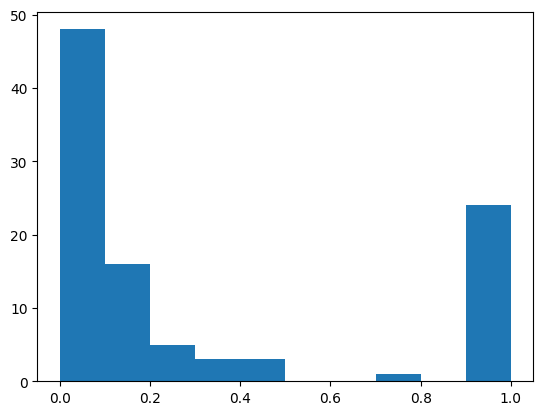

In [52]:
plt.hist(pivots_50, bins=10)

(array([48., 17.,  6.,  4.,  0.,  0.,  1.,  0.,  0., 24.]),
 array([2.76512248e-04, 1.00223475e-01, 2.00170439e-01, 3.00117402e-01,
        4.00064365e-01, 5.00011328e-01, 5.99958292e-01, 6.99905255e-01,
        7.99852218e-01, 8.99799181e-01, 9.99746144e-01]),
 <BarContainer object of 10 artists>)

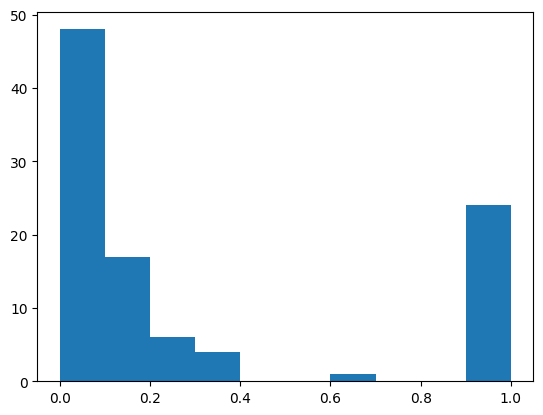

In [53]:
plt.hist(naive_pivots_50, bins=10)

In [54]:
def plot_ecdf(data):
    # Step 2: Sort the data
    data_sorted = np.sort(data)

    # Step 3: Calculate the empirical CDF
    # For each point, the CDF value is the proportion of data points less than or equal to that point
    cdf_values = np.arange(1, len(data_sorted) + 1) / len(data_sorted)

    # Step 4: Plot the empirical CDF
    plt.figure(figsize=(6, 6))
    plt.step(data_sorted, cdf_values, where='post', label='Empirical CDF')
    plt.title('Empirical Cumulative Distribution Function')
    # Add a y=x line
    plt.plot(data_sorted, data_sorted, label='Uniform CDF', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.legend()
    plt.show()


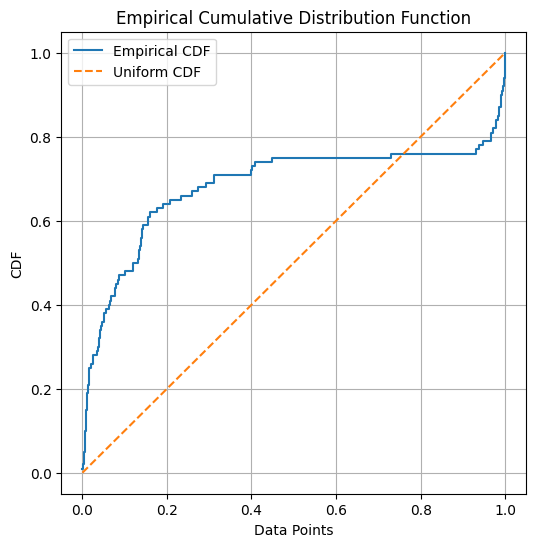

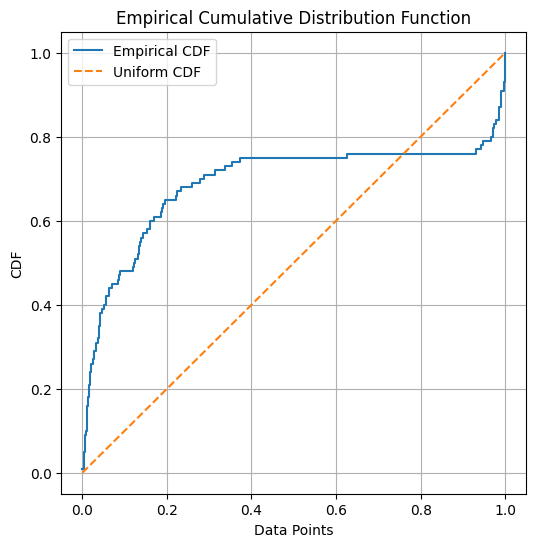

In [57]:
plot_ecdf(pivots_50)
plot_ecdf(naive_pivots_50)

In [56]:
len(pivots_50)

100

In [46]:
unif = np.random.uniform(low=0, high=1, size=50)

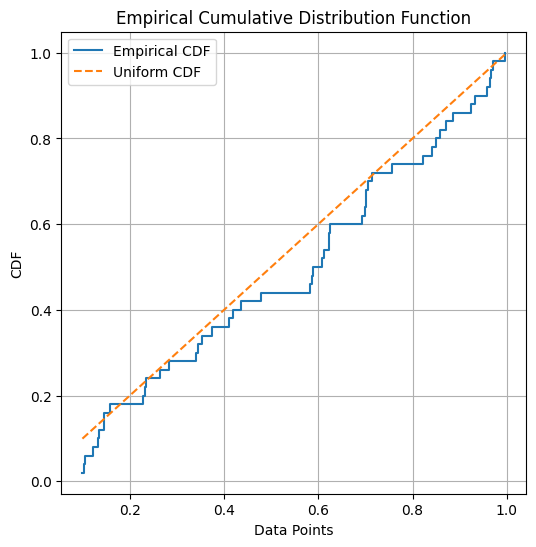

In [47]:
plot_ecdf(unif)